# Comparación de PHL con otros métodos de selección de instancias

In [1]:
import pandas as pd
import numpy as np
import time
import os
import sys

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import f1_score, accuracy_score

from data_reduction.representativeness import find_epsilon

sys.path.append('../')
from my_dataset_reduction import phl_selection, srs_selection, clc_selection, drop3_selection, cnn_selection

import seaborn as sns
import matplotlib.pyplot as plt


dbpath = '../datasets/diabetes_health_indicators/diabetes_binary_5050split_health_indicators_BRFSS2015.csv'
target = 'Diabetes_binary'


SEED = 2025
np.random.seed(SEED)

PROFILING = True # False para tomar todo el dataset, True para tomar una muestra para hacer pruebas rápidas
results_folder = '../results/diabetes_binary_5050split/' if not PROFILING else '../results/diabetes_binary_5050split_profiling/'

# Check if the results folder exists, if not create it
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

In [2]:
df = pd.read_csv(dbpath)

pd.set_option('display.max_columns', None)
print("Tamaño del dataset: ", df.shape)
df.describe()

Tamaño del dataset:  (70692, 22)


Diabetes_binary        HighBP      HighChol     CholCheck  \
count     70692.000000  70692.000000  70692.000000  70692.000000   
mean          0.500000      0.563458      0.525703      0.975259   
std           0.500004      0.495960      0.499342      0.155336   
min           0.000000      0.000000      0.000000      0.000000   
25%           0.000000      0.000000      0.000000      1.000000   
50%           0.500000      1.000000      1.000000      1.000000   
75%           1.000000      1.000000      1.000000      1.000000   
max           1.000000      1.000000      1.000000      1.000000   

                BMI        Smoker        Stroke  HeartDiseaseorAttack  \
count  70692.000000  70692.000000  70692.000000          70692.000000   
mean      29.856985      0.475273      0.062171              0.147810   
std        7.113954      0.499392      0.241468              0.354914   
min       12.000000      0.000000      0.000000              0.000000   
25%       25.000000      0.000000      0.000000              0.000000   
50%       29.000000      0.000000      0.000000              0.000000   
75%       33.000000      1.000000      0.000000              0.000000   
max       98.000000      1.000000      1.000000              1.000000   

       PhysActivity        Fruits       Veggies  HvyAlcoholConsump  \
count  70692.000000  70692.000000  70692.000000       70692.000000   
mean       0.703036      0.611795      0.788774           0.042721   
std        0.456924      0.487345      0.408181           0.202228   
min        0.000000      0.000000      0.000000           0.000000   
25%        0.000000      0.000000      1.000000           0.000000   
50%        1.000000      1.000000      1.000000           0.000000   
75%        1.000000      1.000000      1.000000           0.000000   
max        1.000000      1.000000      1.000000           1.000000   

       AnyHealthcare   NoDocbcCost       GenHlth      MentHlth      PhysHlth  \
count   70692.000000  70692.000000  70692.000000  70692.000000  70692.000000   
mean        0.954960      0.093914      2.837082      3.752037      5.810417   
std         0.207394      0.291712      1.113565      8.155627     10.062261   
min         0.000000      0.000000      1.000000      0.000000      0.000000   
25%         1.000000      0.000000      2.000000      0.000000      0.000000   
50%         1.000000      0.000000      3.000000      0.000000      0.000000   
75%         1.000000      0.000000      4.000000      2.000000      6.000000   
max         1.000000      1.000000      5.000000     30.000000     30.000000   

           DiffWalk           Sex           Age     Education        Income  
count  70692.000000  70692.000000  70692.000000  70692.000000  70692.000000  
mean       0.252730      0.456997      8.584055      4.920953      5.698311  
std        0.434581      0.498151      2.852153      1.029081      2.175196  
min        0.000000      0.000000      1.000000      1.000000      1.000000  
25%        0.000000      0.000000      7.000000      4.000000      4.000000  
50%        0.000000      0.000000      9.000000      5.000000      6.000000  
75%        1.000000      1.000000     11.000000      6.000000      8.000000  
max        1.000000      1.000000     13.000000      6.000000      8.000000

In [3]:
df.head()

Diabetes_binary  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0              0.0     1.0       0.0        1.0  26.0     0.0     0.0   
1              0.0     1.0       1.0        1.0  26.0     1.0     1.0   
2              0.0     0.0       0.0        1.0  26.0     0.0     0.0   
3              0.0     1.0       1.0        1.0  28.0     1.0     0.0   
4              0.0     0.0       0.0        1.0  29.0     1.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  Veggies  HvyAlcoholConsump  \
0                   0.0           1.0     0.0      1.0                0.0   
1                   0.0           0.0     1.0      0.0                0.0   
2                   0.0           1.0     1.0      1.0                0.0   
3                   0.0           1.0     1.0      1.0                0.0   
4                   0.0           1.0     1.0      1.0                0.0   

   AnyHealthcare  NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex  \
0            1.0          0.0      3.0       5.0      30.0       0.0  1.0   
1            1.0          0.0      3.0       0.0       0.0       0.0  1.0   
2            1.0          0.0      1.0       0.0      10.0       0.0  1.0   
3            1.0          0.0      3.0       0.0       3.0       0.0  1.0   
4            1.0          0.0      2.0       0.0       0.0       0.0  0.0   

    Age  Education  Income  
0   4.0        6.0     8.0  
1  12.0        6.0     8.0  
2  13.0        6.0     8.0  
3  11.0        6.0     8.0  
4   8.0        5.0     8.0

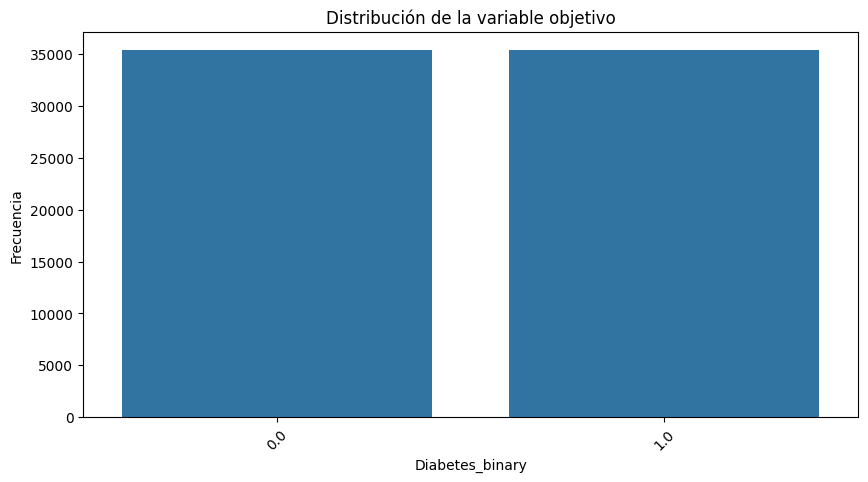

In [4]:
# Show bar plot of the target variable
plt.figure(figsize=(10, 5))
sns.countplot(x=target, data=df)
plt.title('Distribución de la variable objetivo')
plt.xlabel(target)
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

In [5]:
if PROFILING:
    df = df.sample(1000, random_state=SEED)

In [6]:
# Train test split
X = df.drop(columns=[target])
X = np.array(X)

# Convertir la columna target a entero
if not pd.api.types.is_integer_dtype(df[target]):
    le = LabelEncoder()
    y = le.fit_transform(df[target])
else:
    y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [7]:
# Modelos ML
knn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
rf = RandomForestClassifier(n_estimators=100, random_state=SEED)
xgb = XGBClassifier(n_estimators=100, random_state=SEED)

In [8]:
"""
# import pipeline
knn_pl = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', knn)
])

rf_pl = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', rf)
])

xgb_pl = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', xgb)
])
"""

"\n# import pipeline\nknn_pl = Pipeline([\n    ('scaler', StandardScaler()),\n    ('classifier', knn)\n])\n\nrf_pl = Pipeline([\n    ('scaler', StandardScaler()),\n    ('classifier', rf)\n])\n\nxgb_pl = Pipeline([\n    ('scaler', StandardScaler()),\n    ('classifier', xgb)\n])\n"

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
def reduce(X,y,perc,method):
    if method == 'SRS':
        X_red, y_red = srs_selection(X,y,perc)
    if method == 'CLC':
        X_red, y_red = clc_selection(X,y,perc)
    if method == 'PHL':
        X_red, y_red = phl_selection(X, y, 0.05, perc, 'restrictedDim', 2, 'representative')
    return X_red, y_red

models = {'KNN': knn, 'RF': rf, 'XGB': xgb}
reduction_methods = {'SRS': lambda X,y,perc: srs_selection(X,y,perc), 
                     'CLC': lambda X,y,perc: clc_selection(X,y,perc), 
                     'PHL': lambda X,y,perc: phl_selection(X,y,perc=perc, topological_radius=0.05, scoring_version='restrictedDim', dimension=1, landmark_type='representative')}

reduction_methods_without_perc = {'CNN': lambda X,y: cnn_selection(X,y), 
                                'DROP3': lambda X,y: drop3_selection(X,y)}

all_reduction_methods = reduction_methods | reduction_methods_without_perc

percentages = [0.05, 0.1, 0.2, 0.3, 0.5, 0.75, 0.9]
metrics = ['reduction_ratio', 'representativeness', 'accuracy', 'f1', 'training_time', 'reduction_time']

## Test de hiperparámetros de PHL

In [11]:
phl_results = pd.DataFrame(columns=['model', 'reduction_method', 'mode', 'dimensions', 'max_dimension', 'percentage', 'delta'] + metrics)
deltas = [0.02, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 1.0]
modes = ['representative', 'vital'] # if not PROFILING else ['representative']
dimensions = [(1, 'restrictedDim'), (2, 'multiDim'), (0, 'restrictedDim')] # if not PROFILING else [(1, 'restrictedDim')]

if os.path.exists(results_folder + '/phl_results.csv'):
    phl_results = pd.read_csv(results_folder + '/phl_results.csv')
else:
    for model_name in models.keys():
        for mode in modes:
            for dimension, scoring_version in dimensions:
                for percentage in percentages:
                    for delta in deltas:
                        # Reduce the dataset
                        t0 = time.time()
                        X_red, y_red = phl_selection(X_train_scaled, y_train, delta, percentage, scoring_version, dimension, mode)
                        reduction_time = time.time() - t0

                        # Fit the model
                        t0 = time.time()
                        model = models[model_name]
                        model.fit(X_red, y_red)
                        training_time = time.time() - t0

                        # Evaluate the model
                        y_pred_test = model.predict(X_test_scaled)
                        accuracy = accuracy_score(y_test, y_pred_test)
                        f1 = f1_score(y_test, y_pred_test, average='weighted')

                        # Calculate representativeness
                        epsilon = find_epsilon(X_train_scaled, y_train, X_red, y_red)

                        # Store the results
                        phl_results = phl_results.append({
                            'model': model_name,
                            'reduction_method': f'PHL',
                            'mode': mode,
                            'dimensions': scoring_version,
                            'max_dimension': dimension,
                            'percentage': percentage,
                            'delta': delta,
                            'reduction_ratio': len(y_red) / len(y_train),
                            'representativeness': epsilon,
                            'accuracy': accuracy,
                            'f1': f1,
                            'training_time': training_time,
                            'reduction_time': reduction_time,
                        }, ignore_index=True)
    # Save the results
    phl_results.to_csv(f'{results_folder}/phl_results.csv', index=False)

In [12]:
phl_results

model reduction_method            mode     dimensions  max_dimension  \
0      KNN              PHL  representative  restrictedDim              1   
1      KNN              PHL  representative  restrictedDim              1   
2      KNN              PHL  representative  restrictedDim              1   
3      KNN              PHL  representative  restrictedDim              1   
4      KNN              PHL  representative  restrictedDim              1   
...    ...              ...             ...            ...            ...   
1003   XGB              PHL           vital  restrictedDim              0   
1004   XGB              PHL           vital  restrictedDim              0   
1005   XGB              PHL           vital  restrictedDim              0   
1006   XGB              PHL           vital  restrictedDim              0   
1007   XGB              PHL           vital  restrictedDim              0   

      percentage  delta  reduction_ratio  representativeness  accuracy  \
0           0.05   0.02             0.05            7.372411     0.595   
1           0.10   0.02             0.10            7.372411     0.675   
2           0.20   0.02             0.20            5.028464     0.675   
3           0.30   0.02             0.30            4.823831     0.655   
4           0.50   0.02             0.50            4.761314     0.640   
...          ...    ...              ...                 ...       ...   
1003        0.20   1.00             0.20            5.028464     0.685   
1004        0.30   1.00             0.30            4.823831     0.670   
1005        0.50   1.00             0.50            4.823831     0.670   
1006        0.75   1.00             0.75            4.761314     0.715   
1007        0.90   1.00             0.90            5.028464     0.675   

            f1  training_time  reduction_time  
0     0.596680       0.000636        0.037907  
1     0.676345       0.008275        0.037945  
2     0.676379       0.000541        0.037906  
3     0.656464       0.007092        0.037924  
4     0.641081       0.000406        0.037843  
...        ...            ...             ...  
1003  0.685197       0.024495        0.047777  
1004  0.670396       0.028474        0.047783  
1005  0.669010       0.031948        0.047797  
1006  0.715178       0.034132        0.047820  
1007  0.673740       0.034591        0.047852  

[1008 rows x 13 columns]

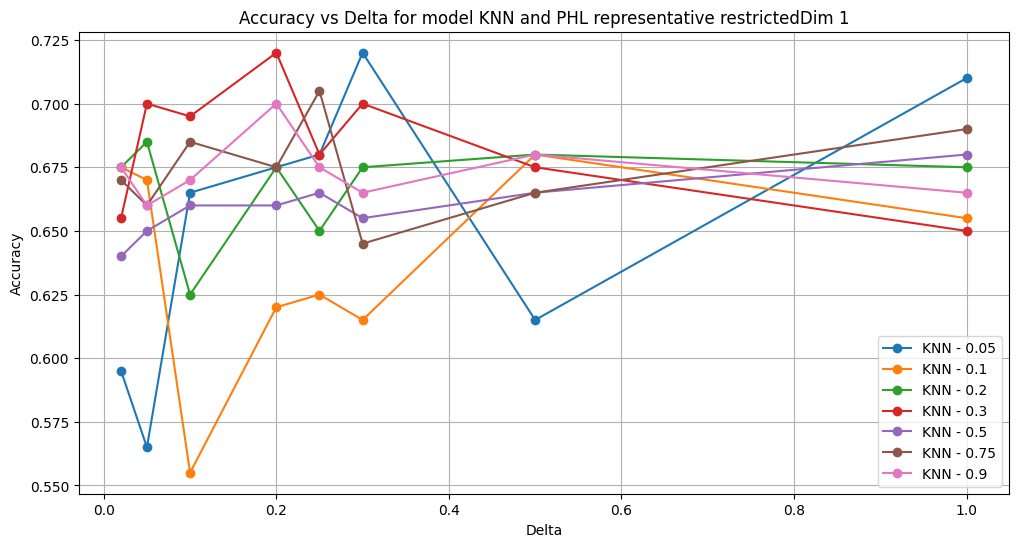

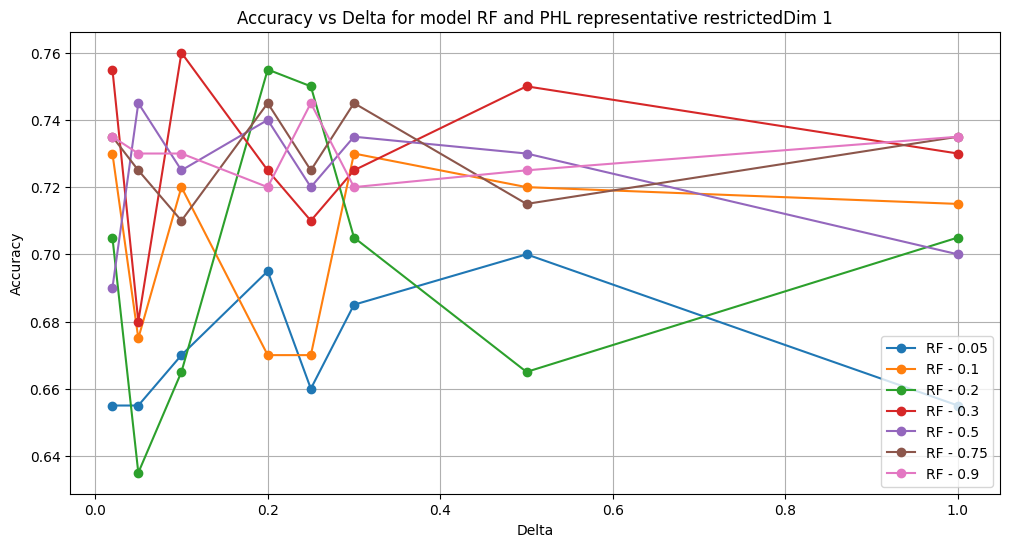

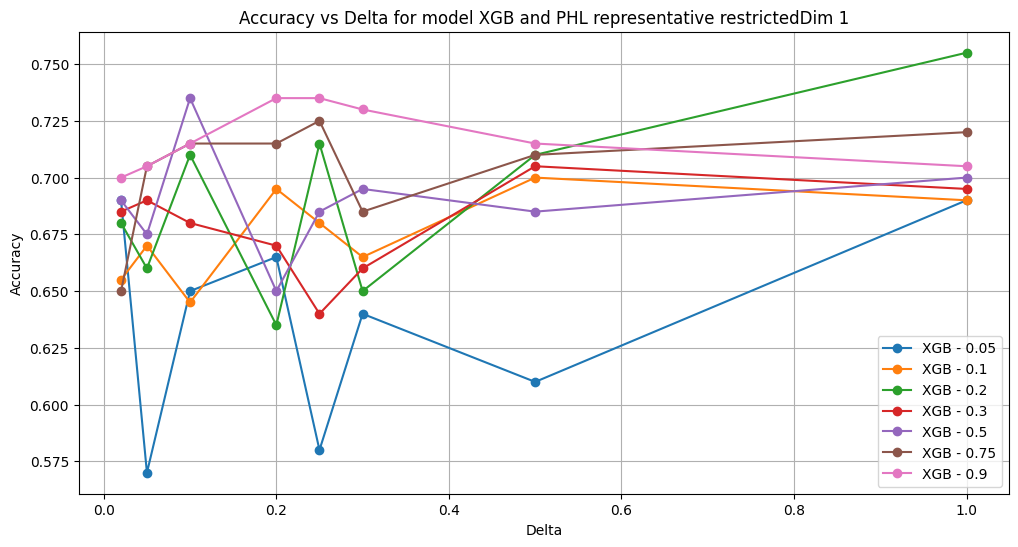

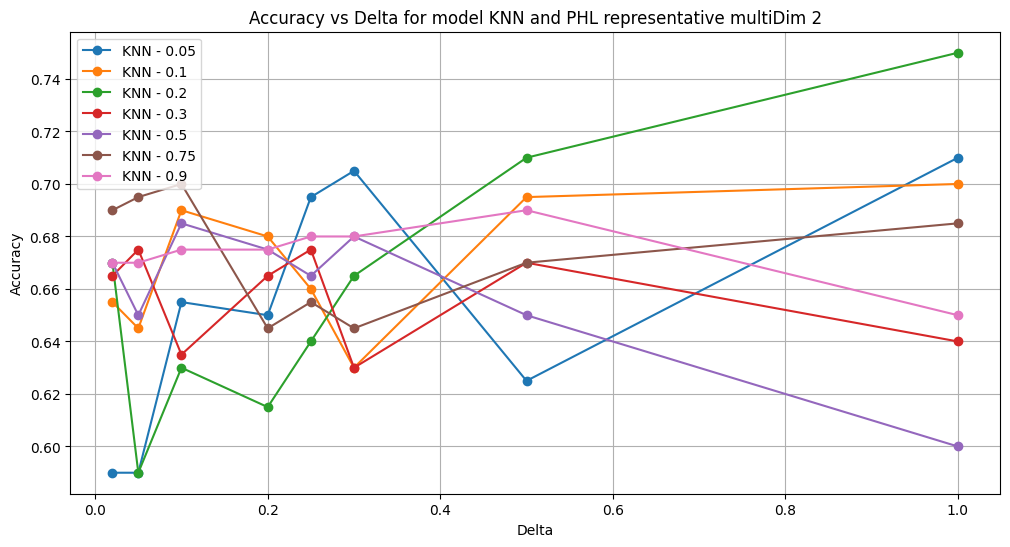

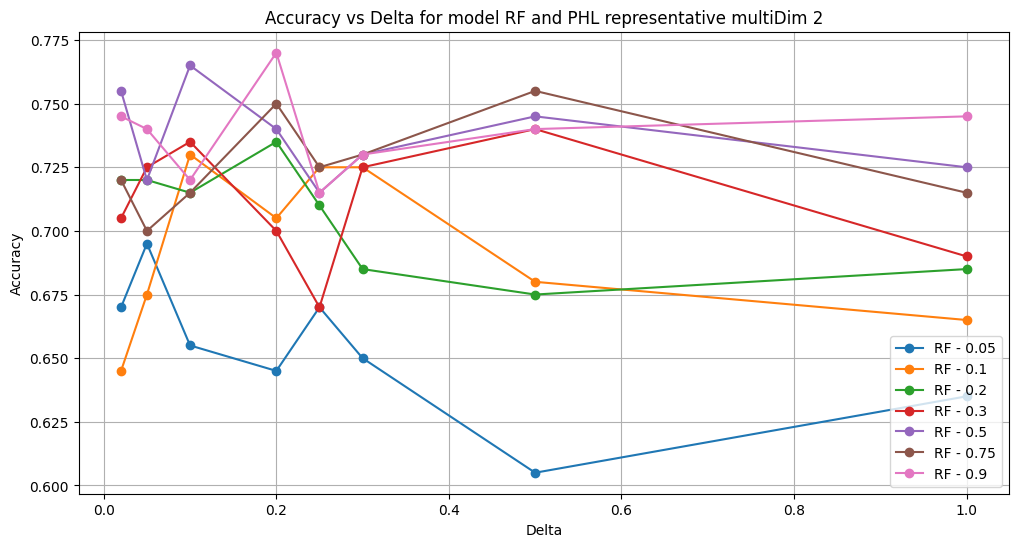

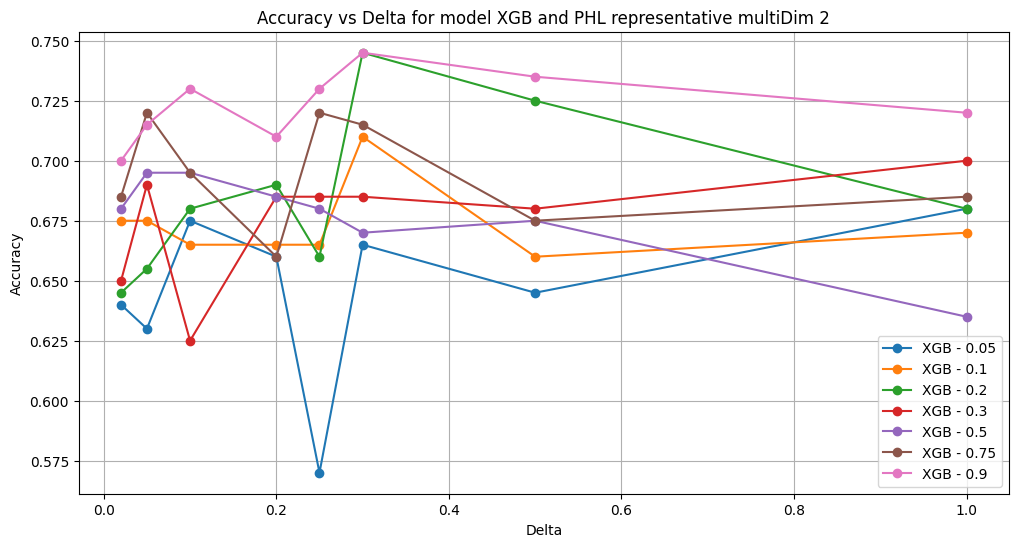

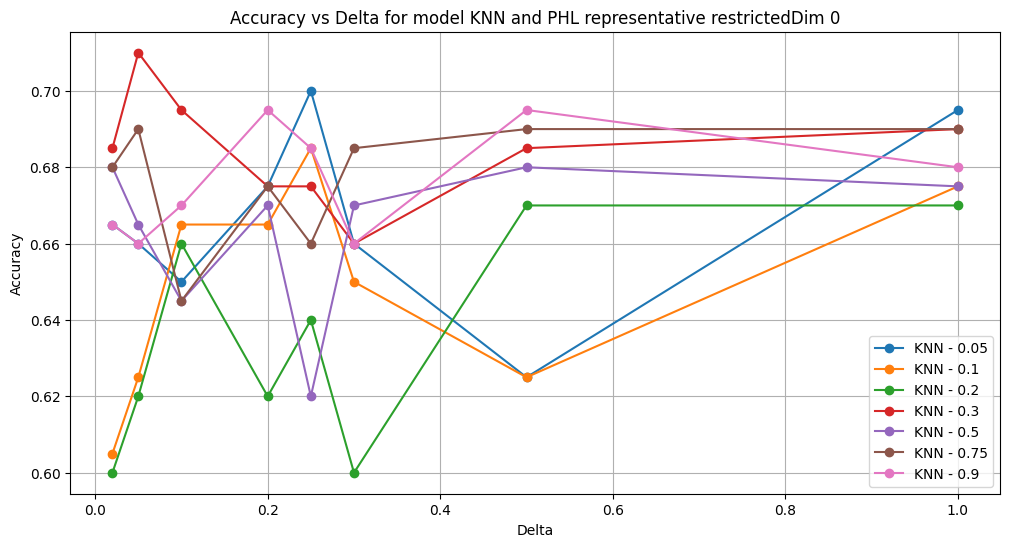

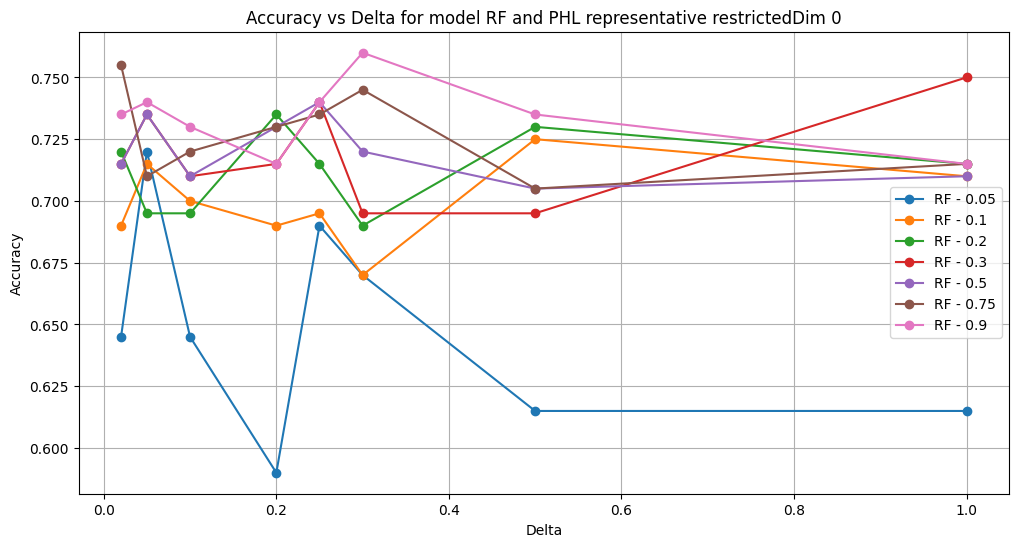

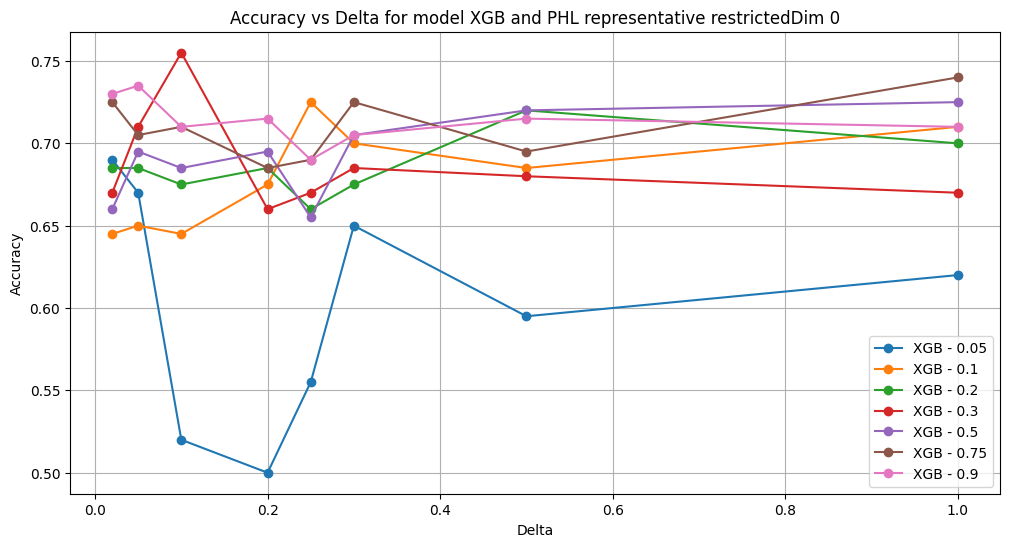

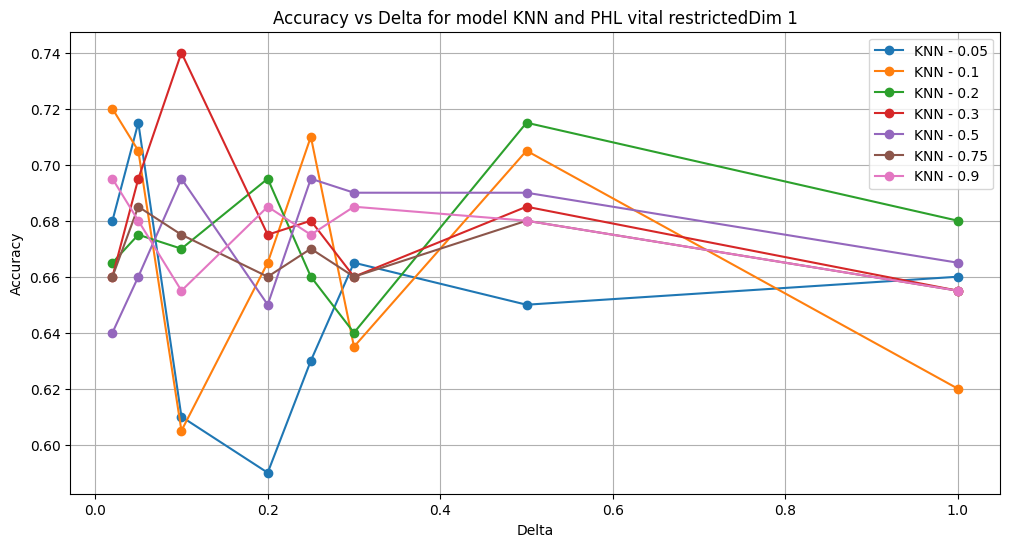

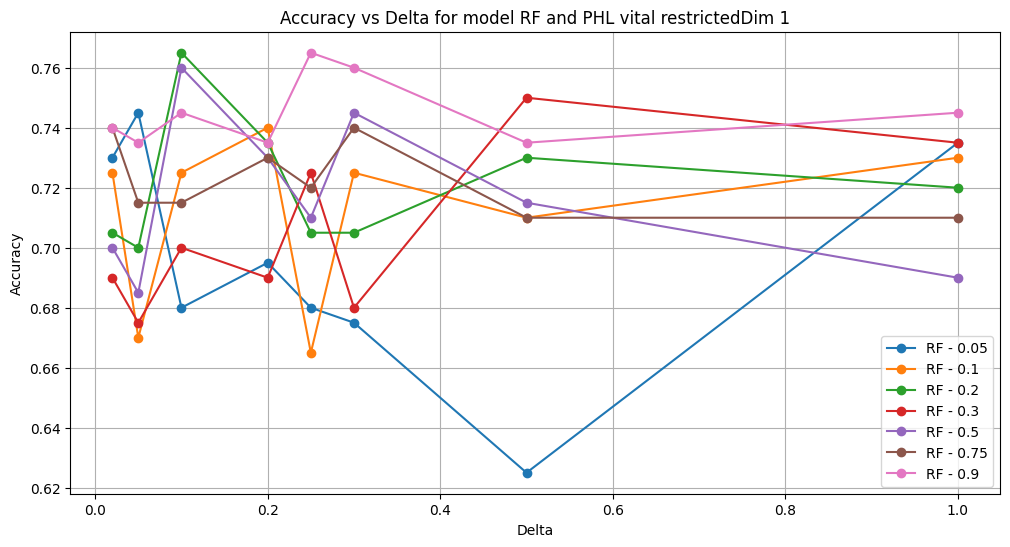

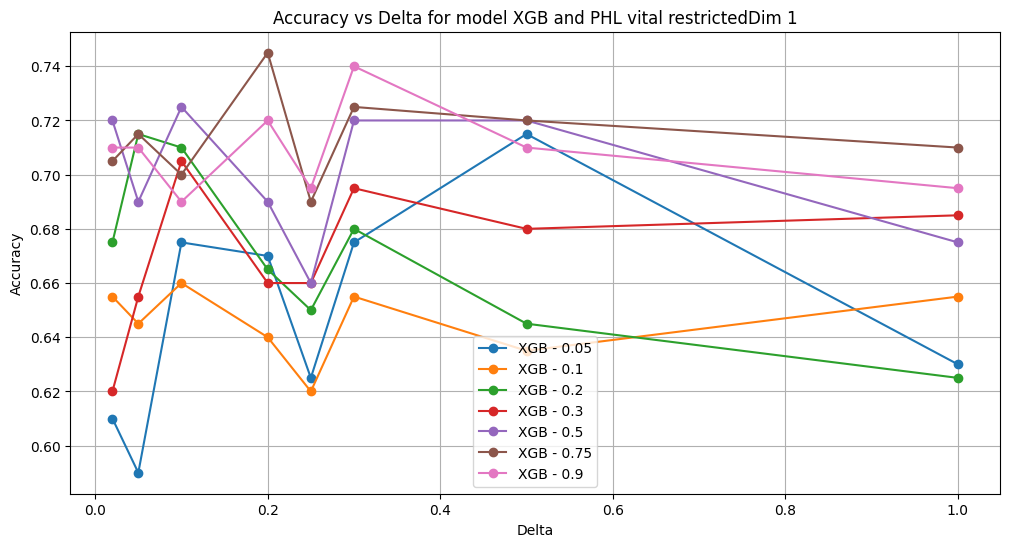

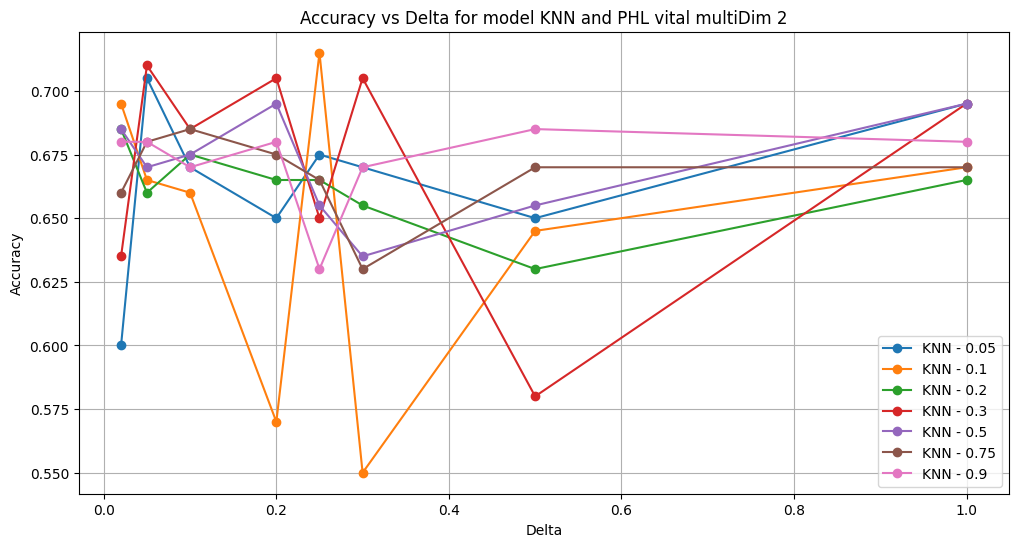

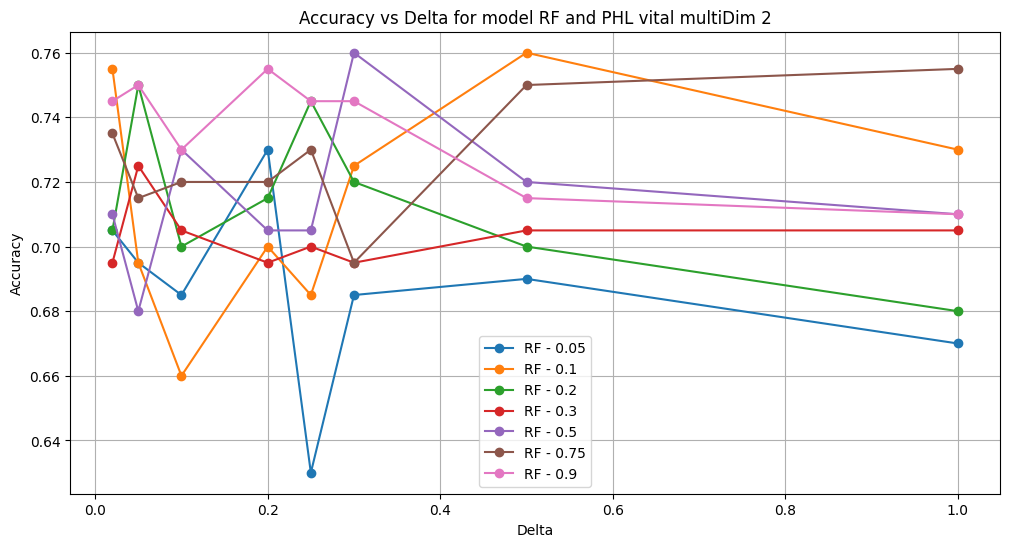

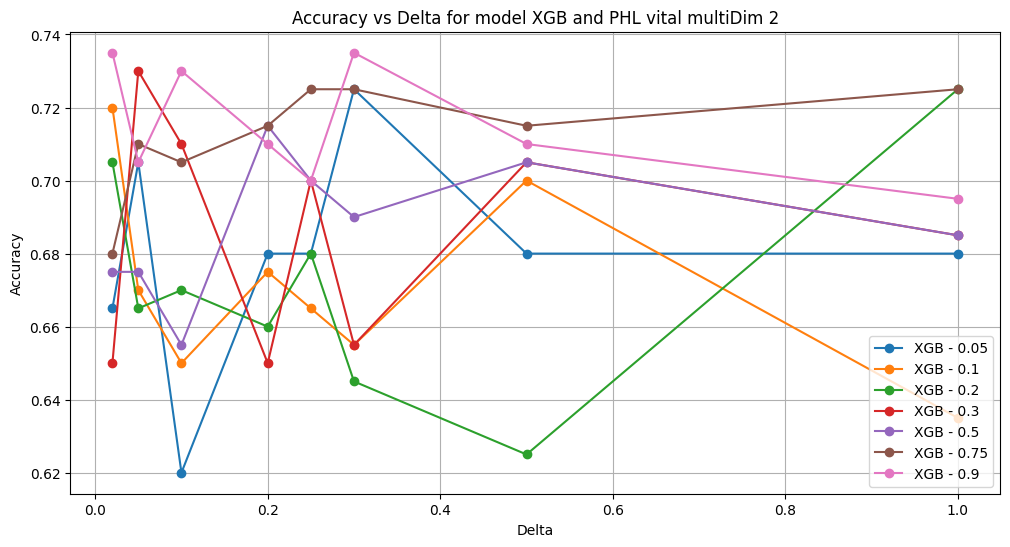

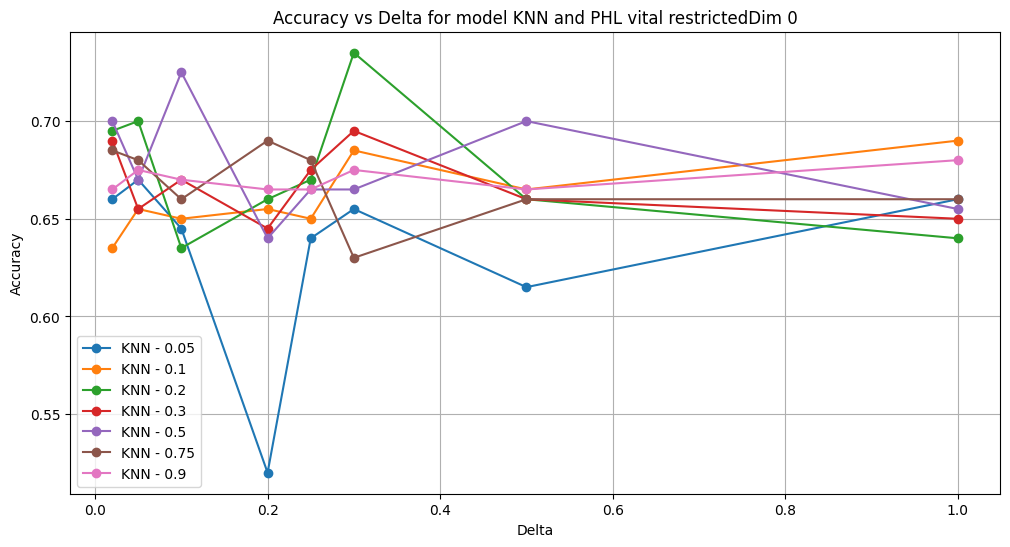

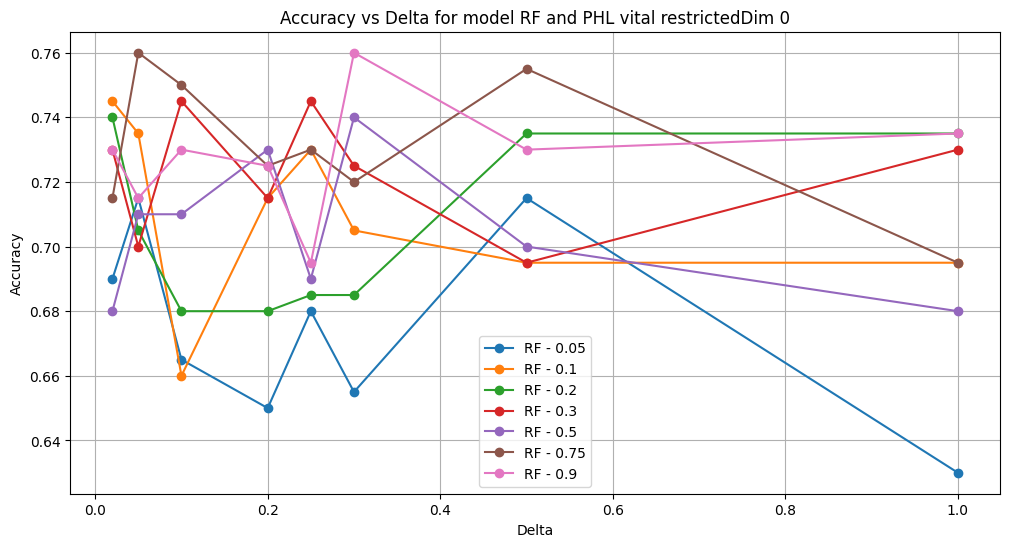

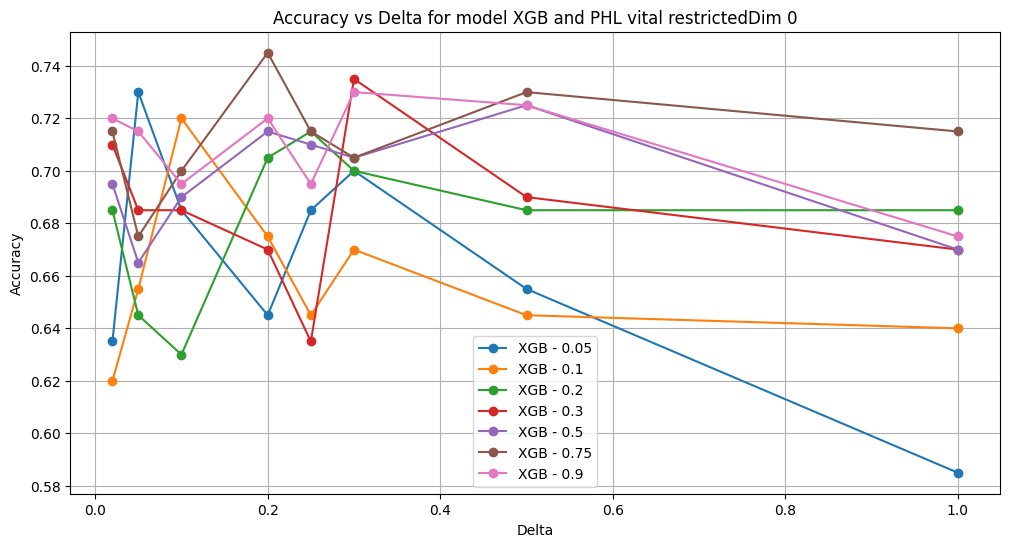

In [13]:
# Show accuracy vs delta for each model
for mode in modes:
    for dimension, scoring_version in dimensions:
        for model_name in models.keys():
            plt.figure(figsize=(12, 6))
            for percentage in percentages:
                plt.plot(phl_results[(phl_results['model'] == model_name) & 
                                     (phl_results['mode'] == mode) & 
                                     (phl_results['dimensions'] == scoring_version) & 
                                     (phl_results['max_dimension'] == dimension) & 
                                     (phl_results['percentage'] == percentage)]
                                     ['delta'],
                        phl_results[(phl_results['model'] == model_name) & 
                                    (phl_results['percentage'] == percentage) &
                                    (phl_results['mode'] == mode) & 
                                    (phl_results['dimensions'] == scoring_version) & 
                                    (phl_results['max_dimension'] == dimension)]
                                    ['accuracy'],
                        label=f'{model_name} - {percentage}', marker='o')
                plt.title(f'Accuracy vs Delta for model {model_name} and PHL {mode} {scoring_version} {dimension}')
                plt.xlabel('Delta')
                plt.ylabel('Accuracy')
                plt.legend()
                plt.grid()
            plt.savefig(f'{results_folder}/accuracy_vs_delta_{model_name}_{mode}_{scoring_version}_{dimension}.png')
            plt.show()

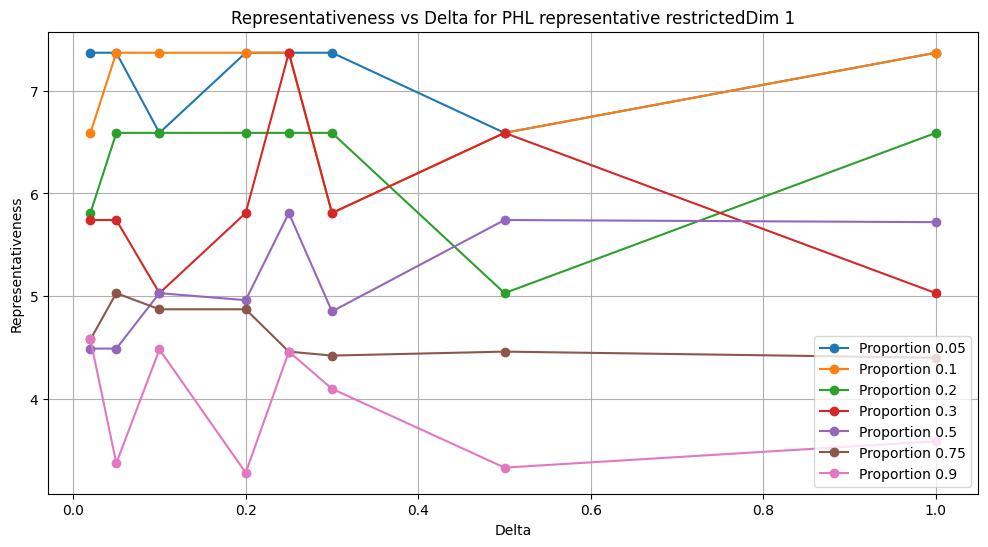

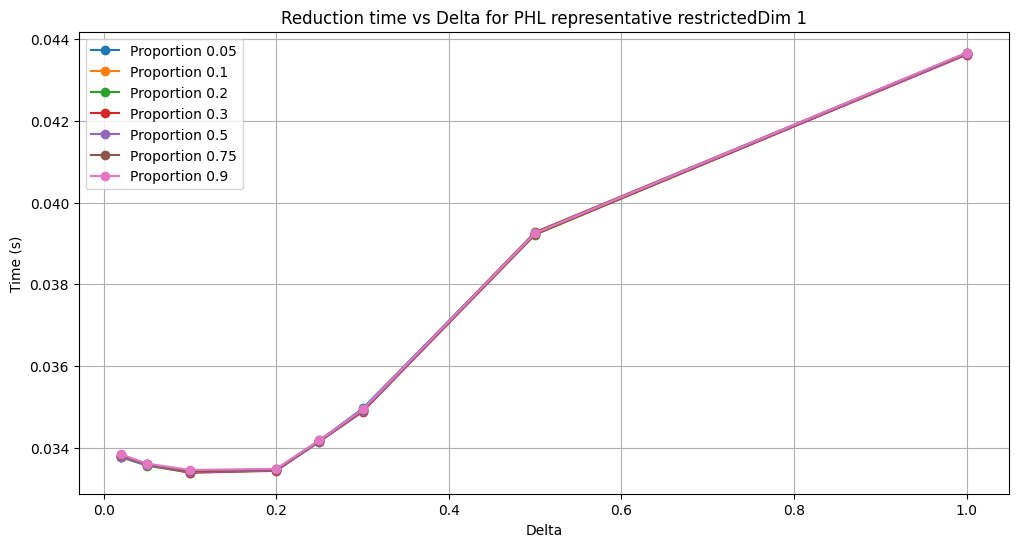

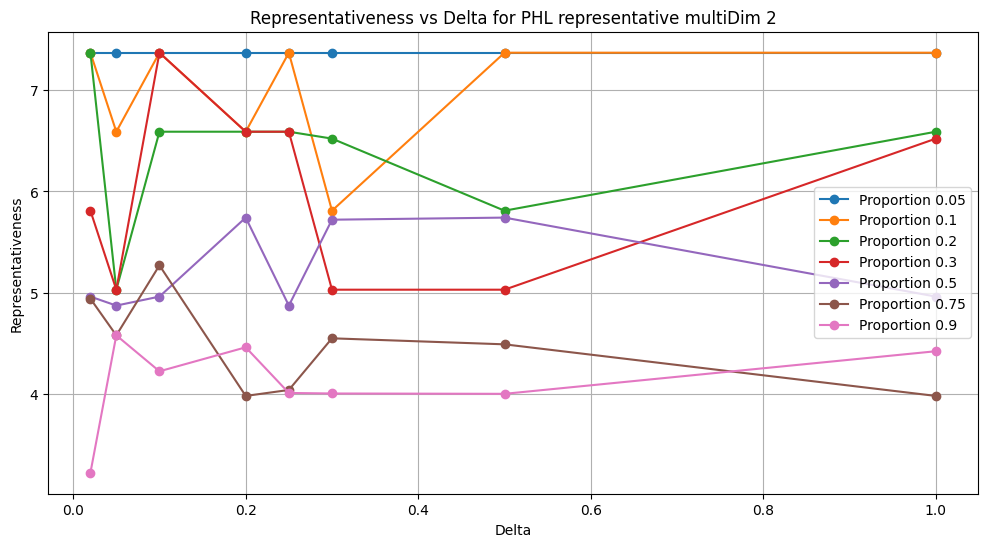

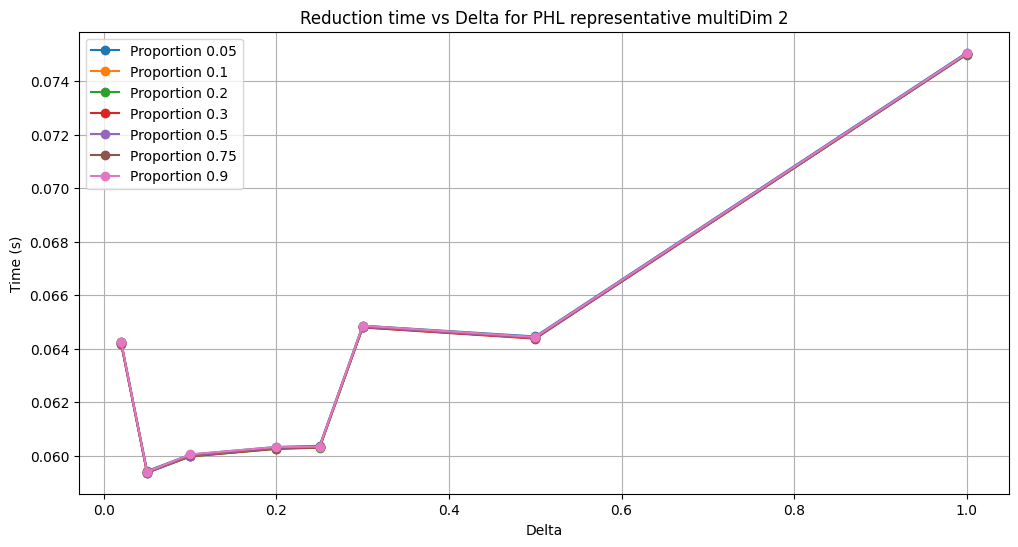

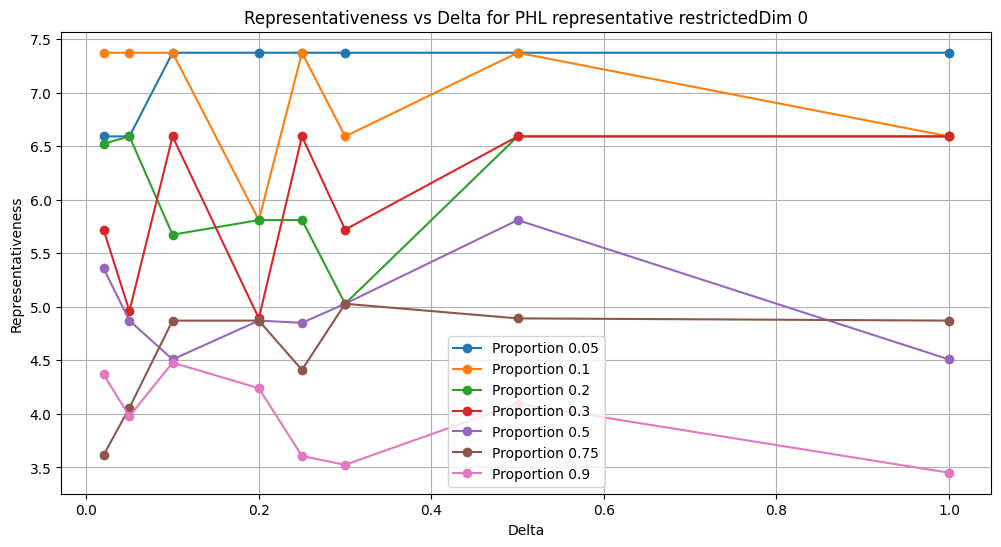

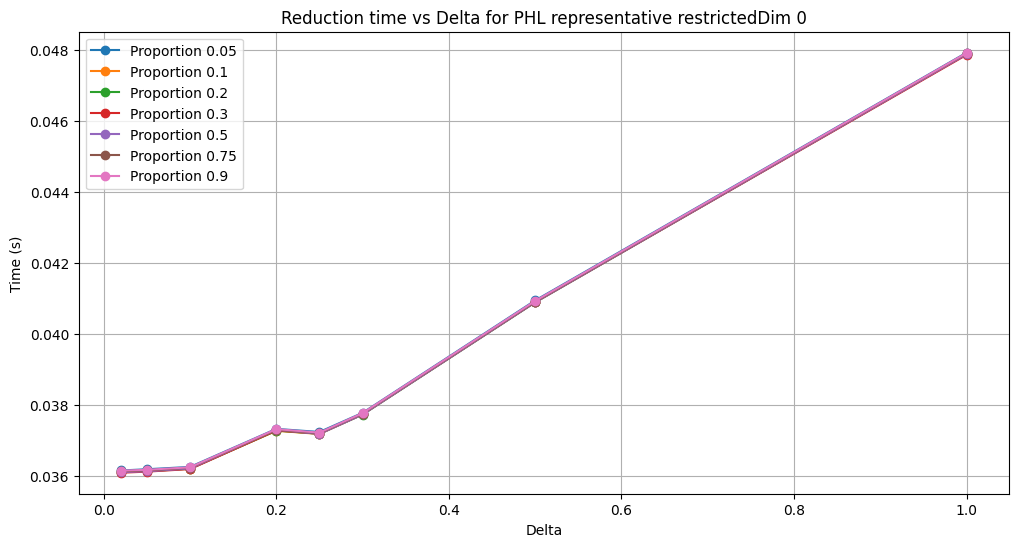

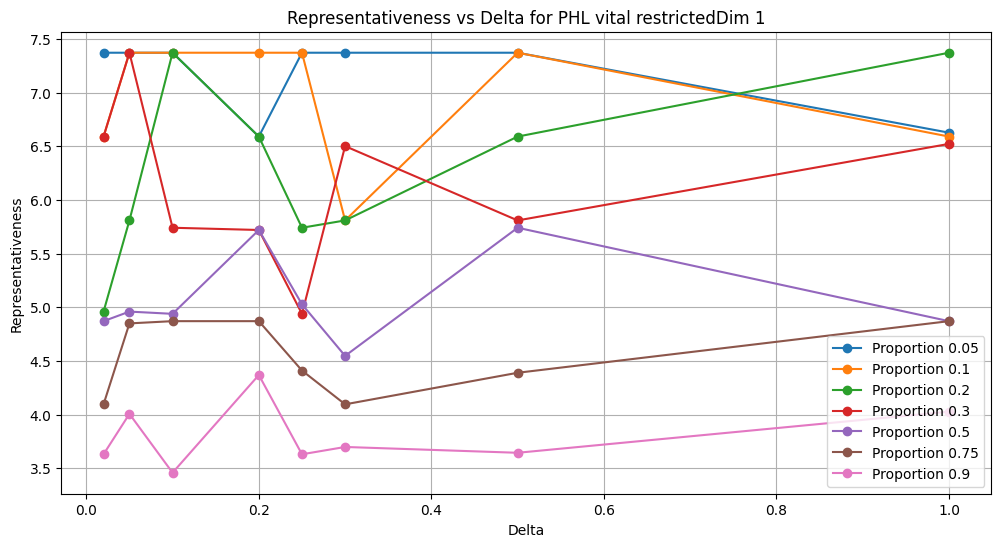

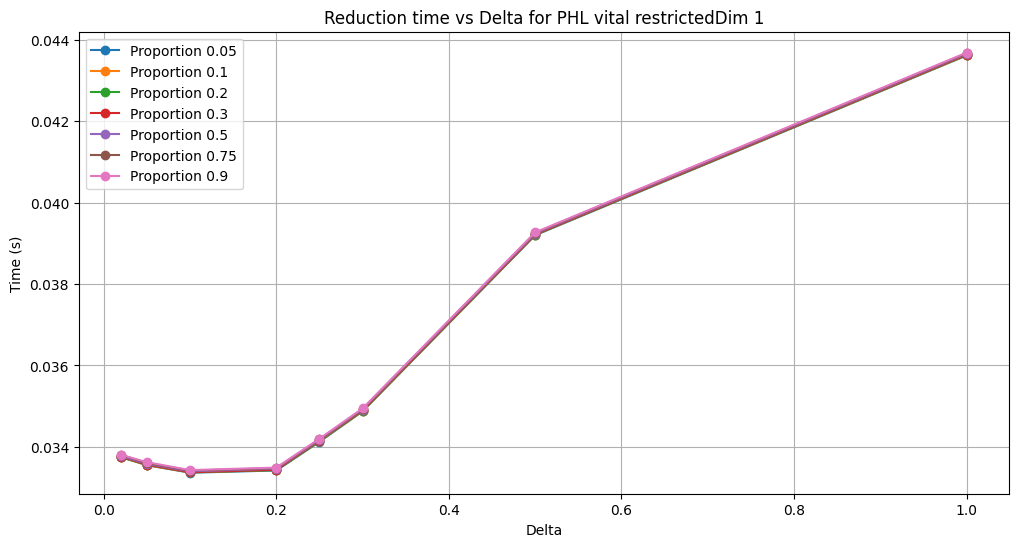

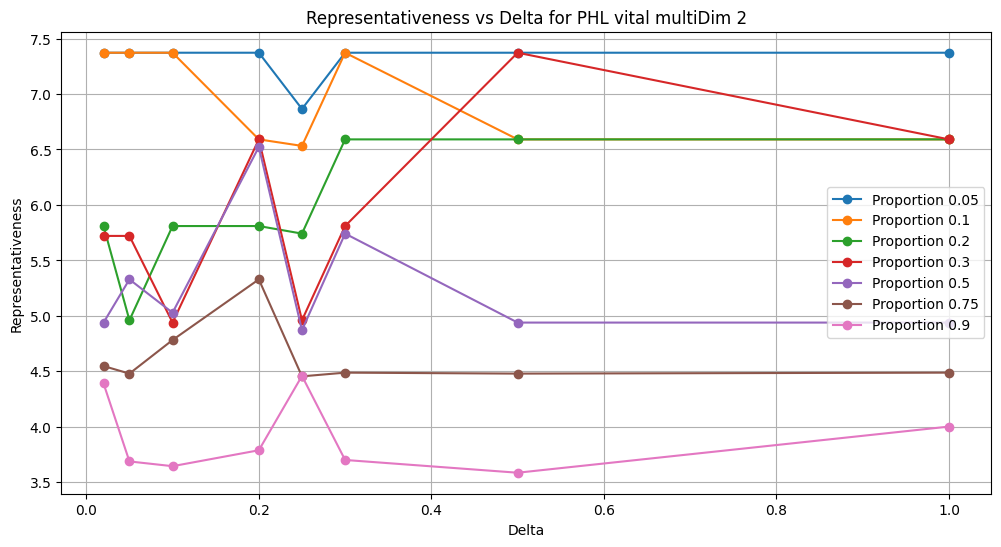

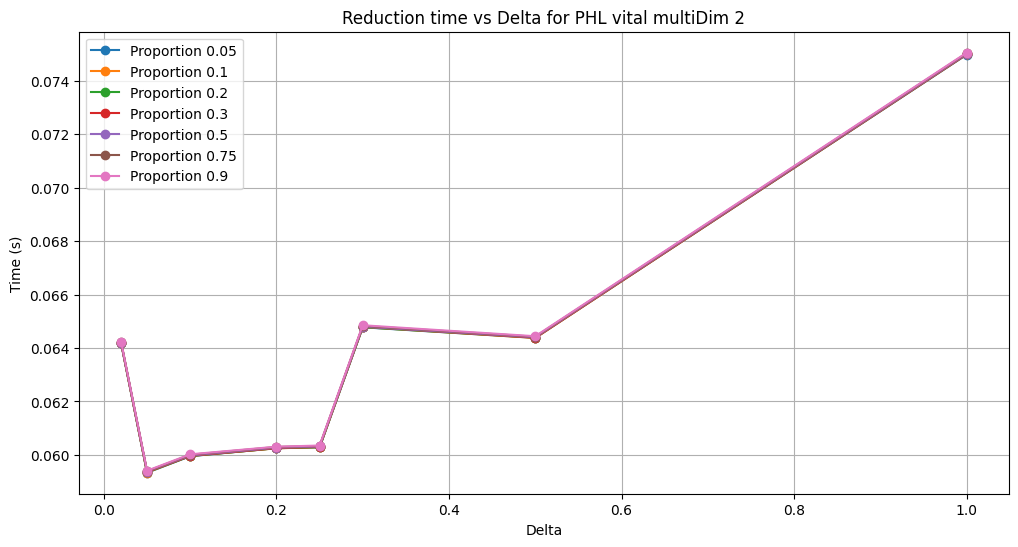

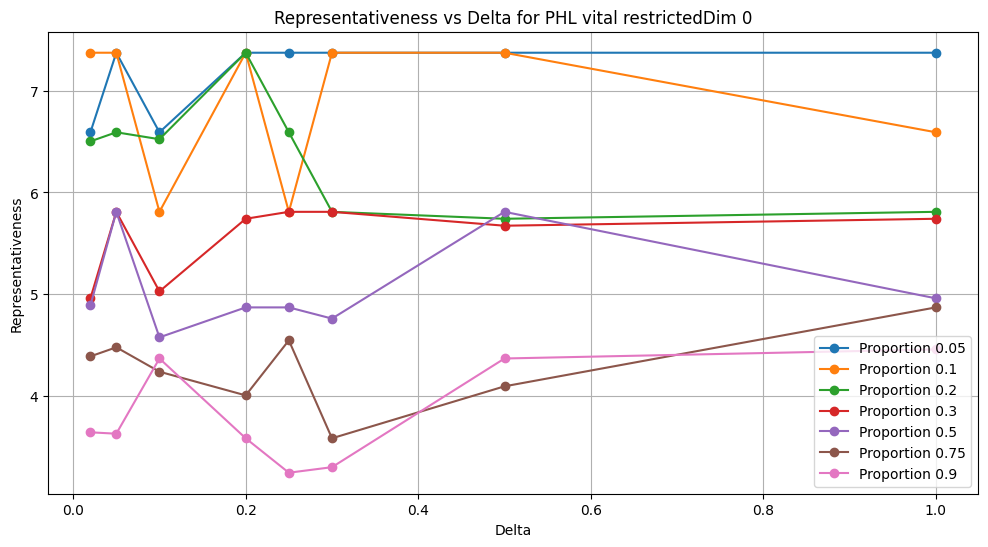

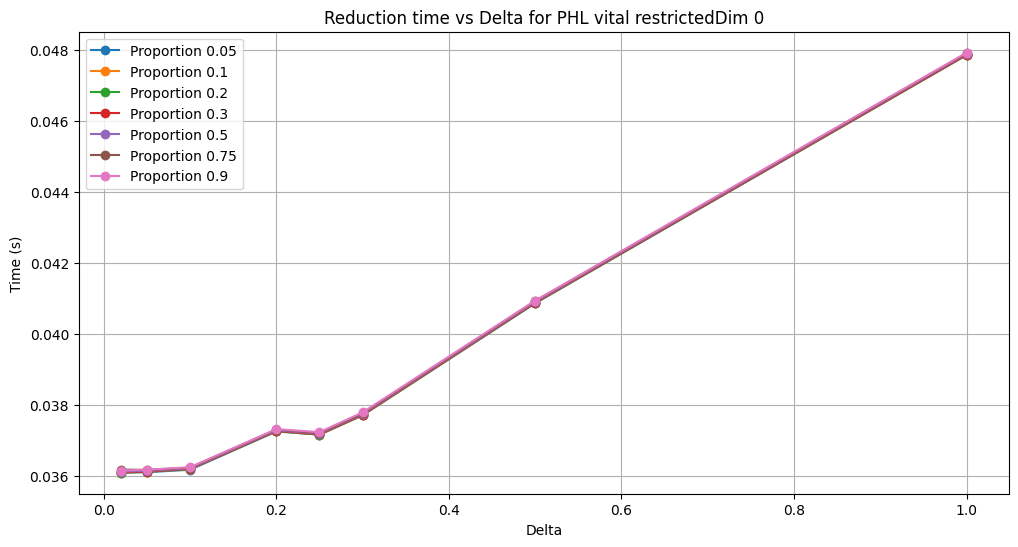

In [14]:
for mode in modes:
    for dimension, scoring_version in dimensions:
        # Get representativeness vs delta averaged by model
        mean_representativeness_phl = (
            phl_results[
                (phl_results['mode'] == mode) &
                (phl_results['dimensions'] == scoring_version) &
                (phl_results['max_dimension'] == dimension) &
                (phl_results['reduction_method'] == 'PHL')
            ]
            .groupby(['delta', 'percentage'])['representativeness']
            .mean()
            .reset_index()
        )
        # Get reduction time vs delta averaged by model
        mean_reduction_time_phl = (
            phl_results[
                (phl_results['mode'] == mode) &
                (phl_results['dimensions'] == scoring_version) &
                (phl_results['max_dimension'] == dimension) &
                (phl_results['reduction_method'] == 'PHL')
            ]
            .groupby(['delta', 'percentage'])['reduction_time']
            .mean()
            .reset_index()
        )

        # Show representativeness vs delta for each percentage
        plt.figure(figsize=(12, 6))
        for percentage in percentages:
            plt.plot(
                mean_representativeness_phl[mean_representativeness_phl['percentage'] == percentage]['delta'],
                mean_representativeness_phl[mean_representativeness_phl['percentage'] == percentage]['representativeness'],
                label=f'Proportion {percentage}', marker='o'
            )
        plt.title(f'Representativeness vs Delta for PHL {mode} {scoring_version} {dimension}')
        plt.xlabel('Delta')
        plt.ylabel('Representativeness')
        plt.legend()
        plt.grid()
        plt.savefig(f'{results_folder}/representativeness_vs_delta_{mode}_{scoring_version}_{dimension}.png')
        plt.show()

        # Show time vs delta
        plt.figure(figsize=(12, 6))
        for percentage in percentages:
            plt.plot(
                mean_reduction_time_phl[mean_reduction_time_phl['percentage'] == percentage]['delta'],
                mean_reduction_time_phl[mean_reduction_time_phl['percentage'] == percentage]['reduction_time'],
                label=f'Proportion {percentage}', marker='o'
            )
        plt.title(f'Reduction time vs Delta for PHL {mode} {scoring_version} {dimension}')
        plt.xlabel('Delta')
        plt.ylabel('Time (s)')
        plt.legend()
        plt.grid()
        plt.savefig(f'{results_folder}/reduction_time_vs_delta_{mode}_{scoring_version}_{dimension}.png')
        plt.show()

## Comparación de métodos de selección de instancias

In [15]:
# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)

results = pd.DataFrame(columns=['model', 'reduction_method', 'percentage'] + metrics)
if os.path.exists(results_folder + '/results.csv'):
    results = pd.read_csv(results_folder + '/results.csv')
else:
    for model_name, model in models.items():
        # Fit the model with the full dataset
        t0 = time.time()
        model.fit(X_train_scaled, y_train)
        t = time.time() - t0

        # Evaluate the model
        y_pred_test = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred_test)
        f1 = f1_score(y_test, y_pred_test, average='weighted')

        epsilon = 1
        # Store the results
        results = results.append({
            'model': model_name,
            'reduction_method': 'None',
            'percentage': 1.0,
            'reduction_ratio': 1.0,
            'representativeness': 0,
            'accuracy': accuracy,
            'f1': f1,
            'training_time': t,
            'reduction_time': 0
        }, ignore_index=True)

        # Fit the model with reduced dataset
        for reduction_method, reduce in reduction_methods.items():
            for percentage in percentages:
                # Reduce the dataset
                t0 = time.time()
                X_red, y_red = reduce(X_train_scaled, y_train, percentage)
                reduction_time = time.time() - t0
                
                # Fit the model
                t0 = time.time()
                model = models[model_name]
                model.fit(X_red, y_red)
                training_time = time.time() - t0

                # Evaluate the model
                y_pred_test = model.predict(X_test_scaled)
                accuracy = accuracy_score(y_test, y_pred_test)
                f1 = f1_score(y_test, y_pred_test, average='weighted')

                # Calculate representativeness
                epsilon = find_epsilon(X_train_scaled, y_train, X_red, y_red)

                # Store the results
                results = results.append({
                    'model': model_name,
                    'reduction_method': reduction_method,
                    'percentage': percentage,
                    'reduction_ratio': len(y_red) / len(y_train),
                    'representativeness': epsilon,
                    'accuracy': accuracy,
                    'f1': f1,
                    'training_time': training_time,
                    'reduction_time': reduction_time,
                }, ignore_index=True)

    # Reduce the dataset with methods that do not require percentage
    for reduction_method, reduce in reduction_methods_without_perc.items():
        # Reduce the dataset
        t0 = time.time()
        X_red, y_red = reduce(X_train_scaled, y_train)
        reduction_time = time.time() - t0

        # Fit the model
        t0 = time.time()
        model = models[model_name]
        model.fit(X_red, y_red)
        training_time = time.time() - t0

        # Evaluate the model
        y_pred_test = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred_test)
        f1 = f1_score(y_test, y_pred_test, average='weighted')

        # Calculate representativeness
        epsilon = find_epsilon(X_train_scaled, y_train, X_red, y_red)

        # Store the results
        results = results.append({
            'model': model_name,
            'reduction_method': reduction_method,
            'percentage': 0,
            'reduction_ratio': len(y_red) / len(y_train),
            'representativeness': epsilon,
            'accuracy': accuracy,
            'f1': f1,
            'training_time': training_time,
            'reduction_time': reduction_time,
        }, ignore_index=True)
        
    # Save the results
    results.to_csv(results_folder + 'results.csv', index=False)

In [16]:
results

model reduction_method  percentage  reduction_ratio  representativeness  \
0    KNN             None        1.00          1.00000            0.000000   
1    KNN              SRS        0.05          0.04875            5.028464   
2    KNN              SRS        0.10          0.09875            7.372411   
3    KNN              SRS        0.20          0.19875            7.372411   
4    KNN              SRS        0.30          0.29875            4.761314   
..   ...              ...         ...              ...                 ...   
63   XGB              PHL        0.50          0.50000            5.028464   
64   XGB              PHL        0.75          0.75000            4.823831   
65   XGB              PHL        0.90          0.90000            5.028464   
66   XGB              CNN        0.00          0.27250            7.372411   
67   XGB            DROP3        0.00          0.26375            7.372411   

    accuracy        f1  training_time  reduction_time  
0      0.665  0.665209       0.000434        0.000000  
1      0.690  0.690000       0.000304        0.000765  
2      0.680  0.676215       0.000297        0.000621  
3      0.735  0.736016       0.000309        0.000639  
4      0.615  0.616282       0.000332        0.000636  
..       ...       ...            ...             ...  
63     0.675  0.676345       0.138330        0.040003  
64     0.695  0.696015       0.131041        0.036532  
65     0.725  0.725474       0.128432        0.036386  
66     0.435  0.263728       0.015327        0.601624  
67     0.655  0.655216       0.032529        0.920558  

[68 rows x 9 columns]

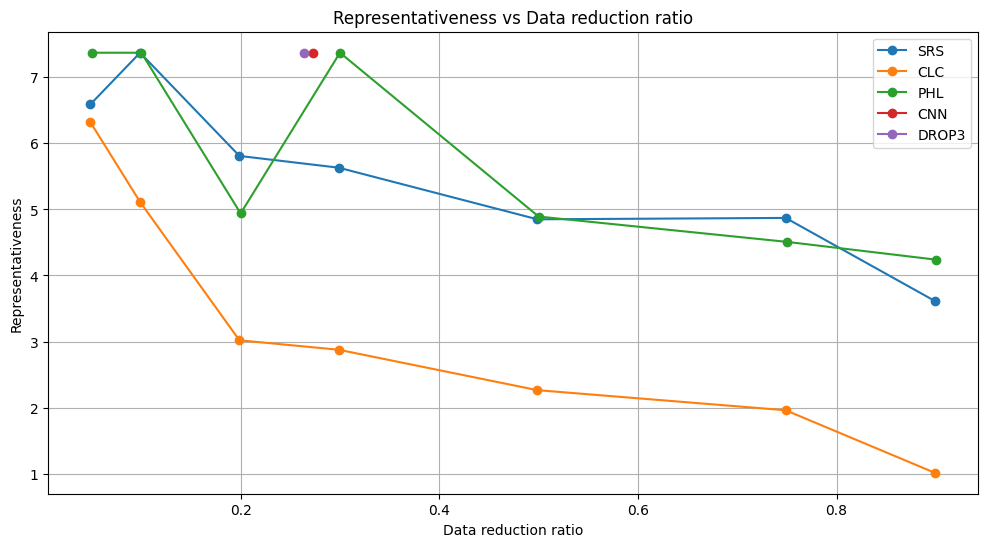

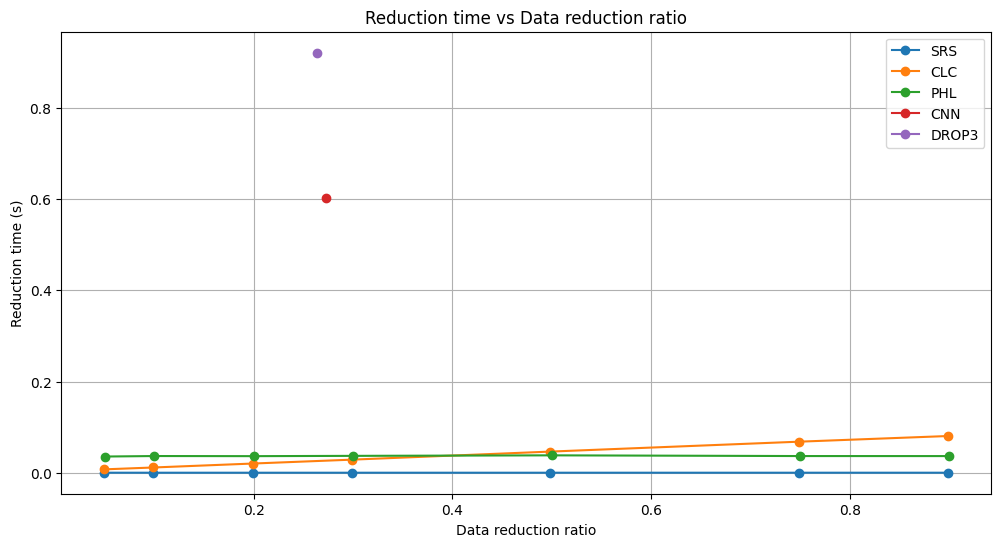

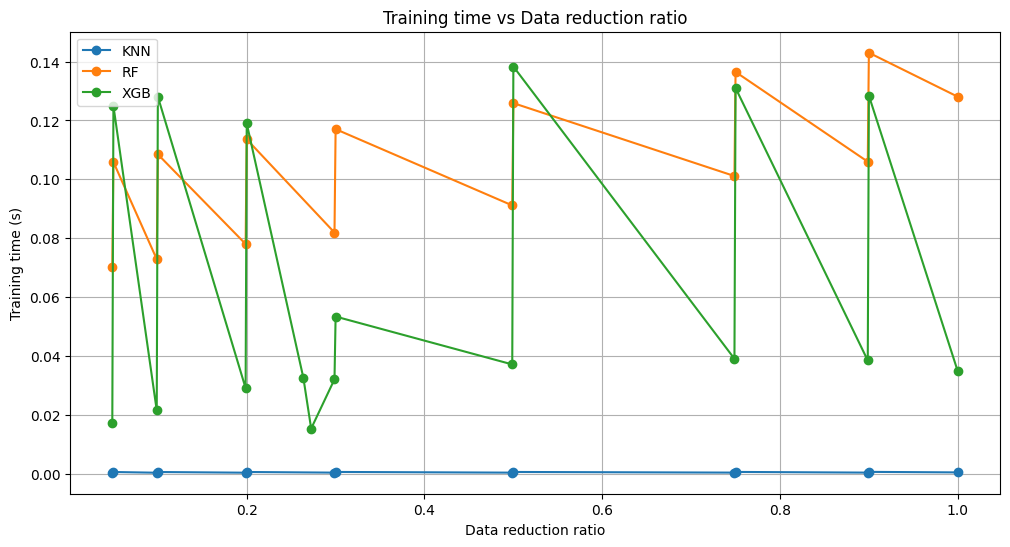

In [17]:
# Mean representativeness vs percentage averaged by model
mean_representativeness = results.groupby(['reduction_method', 'reduction_ratio'])['representativeness'].mean().reset_index()
# Mean reduction time vs percentage averaged by model
mean_reduction_time = results.groupby(['reduction_method', 'reduction_ratio'])['reduction_time'].mean().reset_index()
# Mean training time vs percentage averaged by reduction method
mean_training_time = results.groupby(['model', 'reduction_ratio'])['training_time'].mean().reset_index()

# Plot representativeness vs percentage averaged by model
plt.figure(figsize=(12, 6))
for reduction_method in all_reduction_methods:
    plt.plot(mean_representativeness[mean_representativeness['reduction_method'] == reduction_method]['reduction_ratio'],
             mean_representativeness[mean_representativeness['reduction_method'] == reduction_method]['representativeness'],
             label=reduction_method, marker='o')
    plt.title(f'Representativeness vs Data reduction ratio')
    plt.xlabel('Data reduction ratio')
    plt.ylabel('Representativeness')
    plt.legend()
    plt.grid()
plt.savefig(f'{results_folder}/representativeness_vs_reduction_ratio.png')
plt.show()

# Plot reduction time vs percentage averaged by model
plt.figure(figsize=(12, 6))
for reduction_method in all_reduction_methods:
    plt.plot(mean_reduction_time[mean_reduction_time['reduction_method'] == reduction_method]['reduction_ratio'],
             mean_reduction_time[mean_reduction_time['reduction_method'] == reduction_method]['reduction_time'],
             label=reduction_method, marker='o')
    plt.title(f'Reduction time vs Data reduction ratio')
    plt.xlabel('Data reduction ratio')
    plt.ylabel('Reduction time (s)')
    plt.legend()
    plt.grid()
plt.savefig(f'{results_folder}/reduction_time_vs_reduction_ratio.png')
plt.show()

# Plot training time vs percentage averaged by reduction method
plt.figure(figsize=(12, 6))
for model_name in models.keys():
    plt.plot(mean_training_time[mean_training_time['model'] == model_name]['reduction_ratio'],
             mean_training_time[mean_training_time['model'] == model_name]['training_time'],
             label=model_name, marker='o')
    plt.title(f'Training time vs Data reduction ratio')
    plt.xlabel('Data reduction ratio')
    plt.ylabel('Training time (s)')
    plt.legend()
    plt.grid()
plt.savefig(f'{results_folder}/training_time_vs_percentage.png')
plt.show()


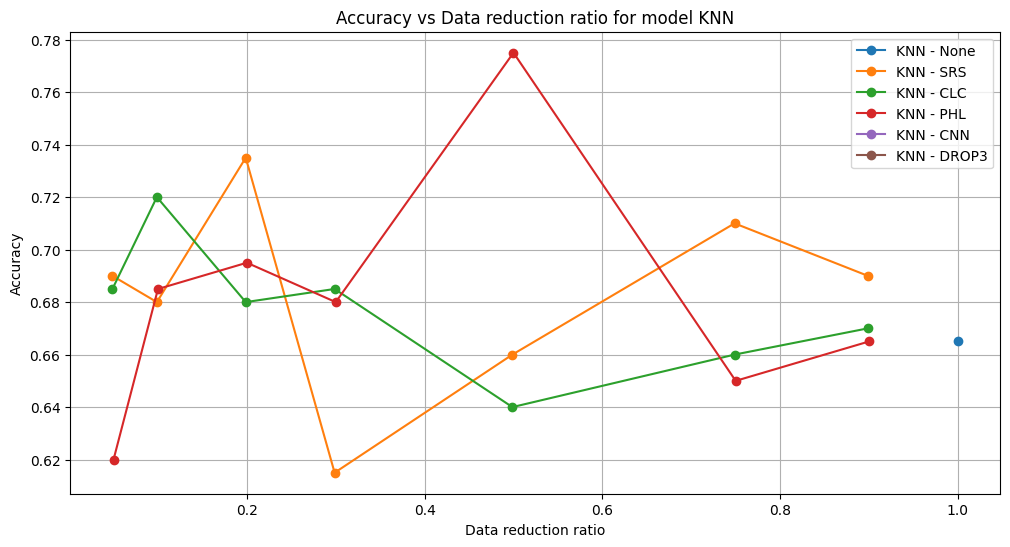

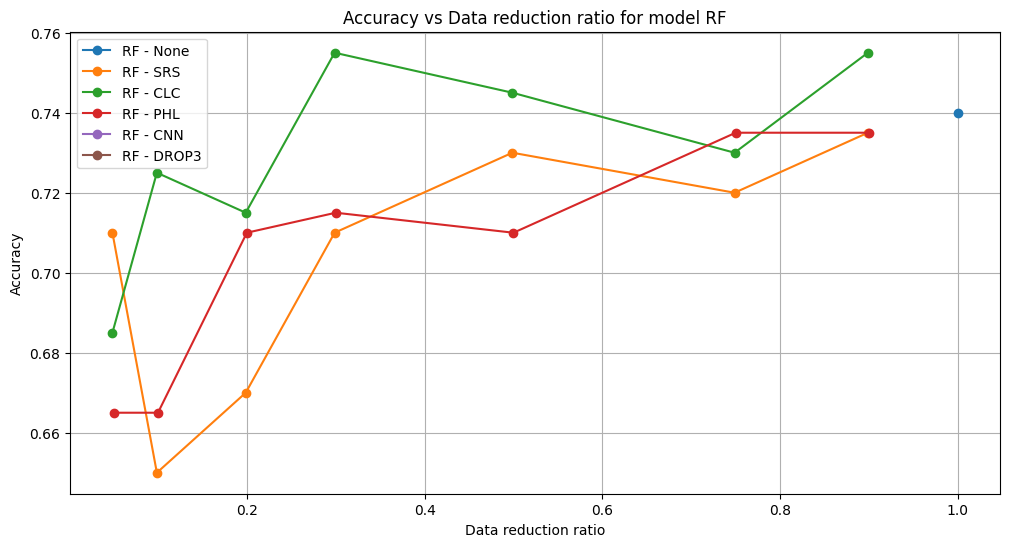

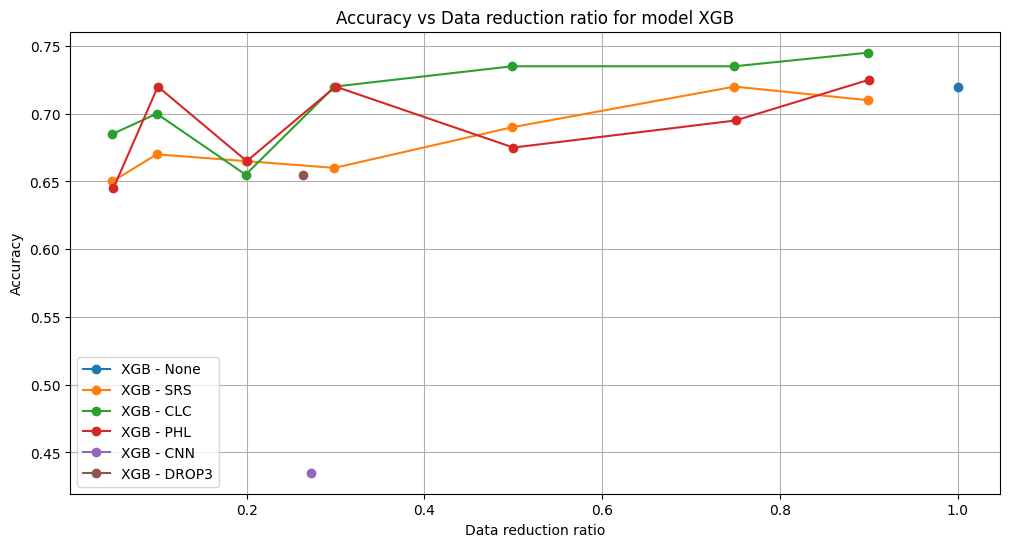

In [18]:
for model_name in models.keys():
    plt.figure(figsize=(12, 6))
    plt.plot(results[(results['model'] == model_name) & (results['reduction_method'] == 'None')]['reduction_ratio'],
             results[(results['model'] == model_name) & (results['reduction_method'] == 'None')]['accuracy'],
             label=f'{model_name} - None', marker='o')
    for reduction_method in all_reduction_methods:
        plt.plot(results[(results['model'] == model_name) & (results['reduction_method'] == reduction_method)]['reduction_ratio'],
                 results[(results['model'] == model_name) & (results['reduction_method'] == reduction_method)]['accuracy'],
                 label=f'{model_name} - {reduction_method}', marker='o')
        plt.title(f'Accuracy vs Data reduction ratio for model {model_name}')
        plt.xlabel('Data reduction ratio')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid()
    plt.savefig(f'{results_folder}/accuracy_vs_percentage_{model_name}.png')
    plt.show()


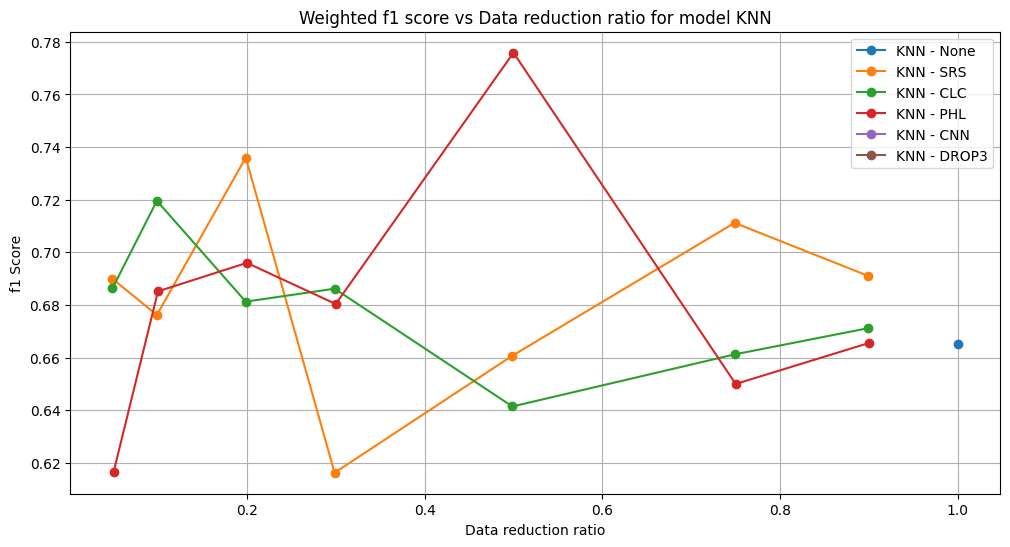

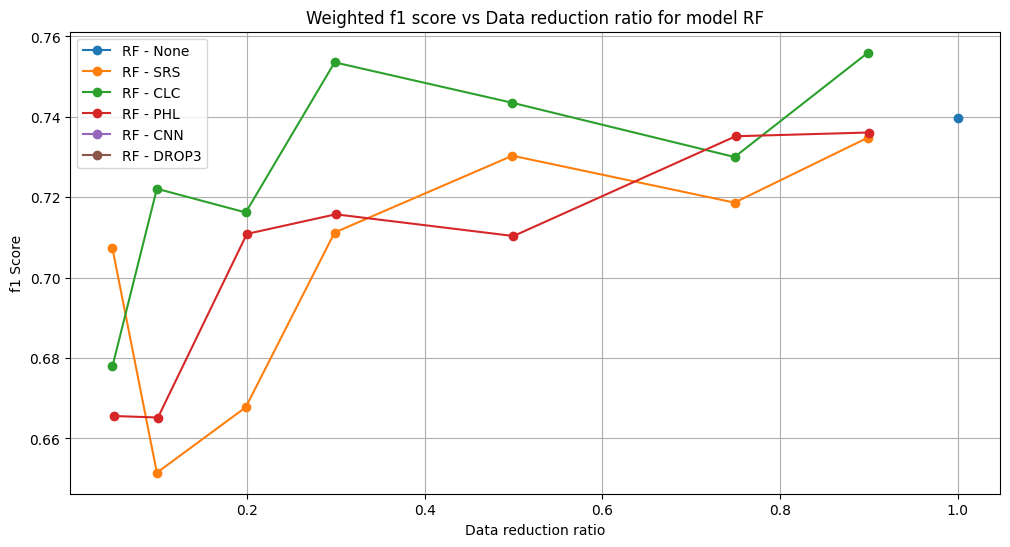

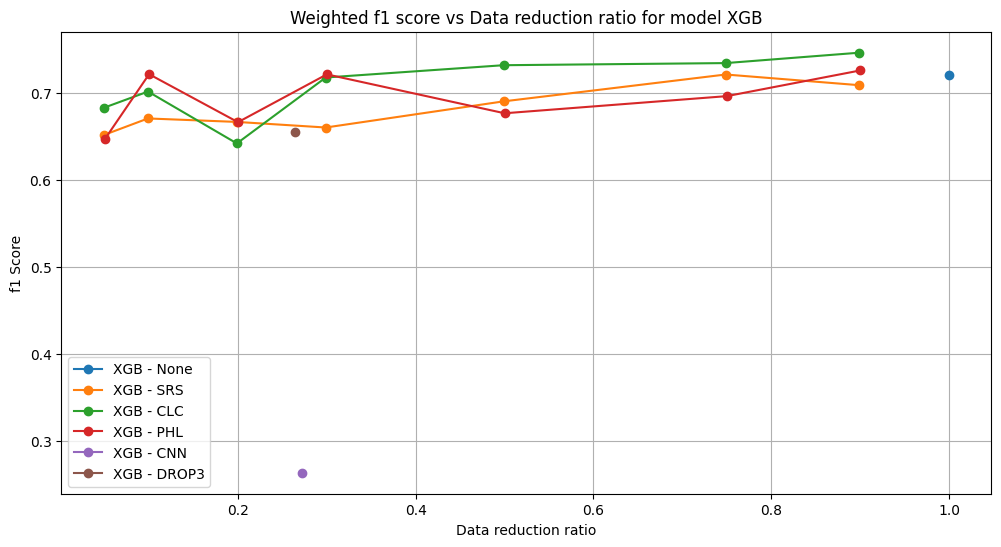

In [19]:
for model_name in models.keys():
    plt.figure(figsize=(12, 6))
    plt.plot(results[(results['model'] == model_name) & (results['reduction_method'] == 'None')]['reduction_ratio'],
             results[(results['model'] == model_name) & (results['reduction_method'] == 'None')]['f1'],
             label=f'{model_name} - None', marker='o')
    for reduction_method in all_reduction_methods:
        plt.plot(results[(results['model'] == model_name) & (results['reduction_method'] == reduction_method)]['reduction_ratio'],
                 results[(results['model'] == model_name) & (results['reduction_method'] == reduction_method)]['f1'],
                 label=f'{model_name} - {reduction_method}', marker='o')
        plt.title(f'Weighted f1 score vs Data reduction ratio for model {model_name}')
        plt.xlabel('Data reduction ratio')
        plt.ylabel('f1 Score')
        plt.legend()
        plt.grid()
    plt.savefig(f'{results_folder}/f1_vs_reduction_ratio_{model_name}.png')
    plt.show()
